In [3]:
# Cell 0: Setup and database test

import sys
import re
from pathlib import Path
import pandas as pd
from IPython.display import display, HTML

# Set project root for Jupyter
project_root = Path("/Users/buddy/Desktop/WGU-Reddit")
sys.path.insert(0, str(project_root))

# Import project modules
from utils.paths import DATA_DIR, OUTPUT_DIR, DB_PATH, path
from utils.db_connection import get_db_connection, load_posts_dataframe
from utils.cleaning_functions import cleaning_vader, cleaning_ngrams
from utils.sentiment import calculate_vader_sentiment, analyze_proximity_sentiment
from utils.filters import apply_filters

# Load course list
course_list = pd.read_csv(DATA_DIR / "courses_with_college_v10.csv")
output_dir = OUTPUT_DIR
# Load posts from DB
df = load_posts_dataframe()

# Confirm setup
print(f"Project root: {project_root}")
print(f"Input dir: {DATA_DIR}")
print(f"Output dir: {OUTPUT_DIR}")
print(f"Loaded {len(df)} rows.")
print(df.columns)


Project root: /Users/buddy/Desktop/WGU-Reddit
Input dir: /Users/buddy/Desktop/WGU-Reddit/data
Output dir: /Users/buddy/Desktop/WGU-Reddit/outputs
Loaded 19001 rows.
Index(['post_id', 'title', 'selftext', 'permalink'], dtype='object')


In [4]:
# Cell: Run VADER cleaning (no NLTK)

from utils.cleaning_functions import cleaning_vader

df_vader = cleaning_vader(df)
print(f"{len(df)} rows.")

display(df_vader[['post_id','text_clean', 'text_length']].head(5))

19001 rows.


,post_id,text_clean,text_length
0,1k6jeqd,Examity I’m curious as to how examity works. I...,495
1,1k6j88n,Any Canadians here pursuing software developme...,572
2,1k6iufu,ANYONE IN D277 I’m half way through Front End ...,228
3,1k6hw8z,DING! Finally!! It's been a rough 2 years for ...,1742
4,1k6gjrk,Anyone ever have a capstone returned for revis...,50


In [5]:
from utils.filters import apply_filters

# Setup filter configuration
filters_config = {
    'length': {
        'enabled': True,
        'params': {'min_length': 10, 'max_length': 1000}
    },
    'course_codes': {
        'enabled': True,
        'params': {
            'course_codes': course_list["CourseCode"].dropna().astype(str).tolist(),
            'exact_match_count': 1
        }
    },
    'questions': {'enabled': False},
    'sentiment': {'enabled': False},
}

# Apply filters
df_filtered = apply_filters(df_vader, filters_config)



[filter_by_length] 16602 posts kept (length 10-1000)
[filter_by_course_codes] 4294 posts matched 1 course codes


In [6]:
# Cell: Run VADER sentiment on filtered posts

df_filtered_vader = calculate_vader_sentiment(df_filtered)
print(f"Loaded {len(df_filtered_vader)} rows.")
print(df_filtered_vader.columns)
# Preview top/bottom sentiment from filtered set
from utils.render import render_table
print("df_filtered_vader:", df_filtered_vader.columns)
render_table(df_filtered_vader.head(1).sort_values(by='VADER_Compound', ascending=False), title="Top Sentiment (Filtered)")
render_table(df_filtered_vader.head(1).sort_values(by='VADER_Compound'), title="Bottom Sentiment (Filtered)")

[calculate_vader_sentiment] VADER sentiment scored for 4294 posts.
Loaded 4294 rows.
Index(['post_id', 'title', 'selftext', 'permalink', 'text_clean',
       'text_length', 'matched_course_codes', 'VADER_Compound'],
      dtype='object')
df_filtered_vader: Index(['post_id', 'title', 'selftext', 'permalink', 'text_clean',
       'text_length', 'matched_course_codes', 'VADER_Compound'],
      dtype='object')
[render_table]  Showing 1 of 1 total posts


post_id,title,selftext,text_length,matched_course_codes,VADER_Compound,permalink
1k6iufu,ANYONE IN D277,"I’m half way through Front End Web Development (D277) and i’ve reached an impasse…JavaScript. Looking for anyone and everyone who can possibly understand JavaScript loops, functions, as arrays. \n\nMuch appreciated (:...",228,[D277],0.7845,link


[render_table]  Showing 1 of 1 total posts


post_id,title,selftext,text_length,matched_course_codes,VADER_Compound,permalink
1k6iufu,ANYONE IN D277,"I’m half way through Front End Web Development (D277) and i’ve reached an impasse…JavaScript. Looking for anyone and everyone who can possibly understand JavaScript loops, functions, as arrays. \n\nMuch appreciated (:...",228,[D277],0.7845,link


In [7]:
print("df_filtered_vader columns:", df_filtered_vader.columns.tolist())
print("df_filtered_vader number of posts:", len(df_filtered_vader))

df_filtered_vader columns: ['post_id', 'title', 'selftext', 'permalink', 'text_clean', 'text_length', 'matched_course_codes', 'VADER_Compound']
df_filtered_vader number of posts: 4294


In [8]:
# Filter for strongly negative posts (compound ≤ -0.6)
df_neg_vader = df_filtered_vader[df_filtered_vader['VADER_Compound'] <= -0.6]
print("df_neg_vader columns:", df_neg_vader.columns.tolist())
print("df_neg_vader number of posts:", len(df_neg_vader))

df_neg_vader columns: ['post_id', 'title', 'selftext', 'permalink', 'text_clean', 'text_length', 'matched_course_codes', 'VADER_Compound']
df_neg_vader number of posts: 405


In [9]:
df2 = vader_sentiment_spotlight(df_neg_vader)
generate_sentiment_spotlight(df2)

[vader_sentiment_spotlight] Analyzing sentiment for 405 posts...
[generate_sentiment_spotlight] Displaying 10 posts with negative sentiment words highlighted


Post ID,Content
1k66sct (4 negative words),"Title: Can’t seem to pass C955 Content: To say that I’m beyond depressed and disappointed would be an understatement. I’ve taken the OA for this course twice and have failed both times. I don’t understand what I’m doing. I’ve watched the cohorts, I’ve done the study plans, yet I’ve failed twice. Guess I just need some encouraging words, tips, or advice 😔"
1k4wr2u (8 negative words),"Title: D334 - Intro to Cryptography - Is there an electronic whiteboard? Content: I am cramming for D334, and there is this cheat sheet that you are supposed to memorize and dump to a whiteboard before you start... I don't like the actual whiteboard, but I do like dumping everything to the whiteboard on the right edge, along with the calculator, you know, like in the PA... So can anyone confirm that the D334 OA has the whiteboard on the right side of the screen that I can use to make my info dump at the beginning of the test and use it for reference during the test? I am practicing at work, dumping it all into notepad and checking for errors. I have 5 classes left and 3 months to go, so I have plenty of time, not trying to rush it. Working on memorizing and dumping this cheat sheet I found in some other posts. But like I said, can anyone who has taken the OA recently confirm that the whiteboard is available? It is during the PA. Thanks!"
8rvvxh (2 negative words),"Title: C214 help! Content: This class is going to be the death of me! I have watched all the videos, I have done the study guide and webinars and it just isn't sticking. If I don't pass OA by end of week, my whole plan will be off and that is adding even more stress. Any extra tips or tricks?"
1jxp6nb (3 negative words),Title: Isc2 ssp Content: I am miserable and dragging myself through the linkd in learning currently and kind of pissed off because I feel like it’s just the sec+ and tons of the other courses I’ve done already. I’m halfway through this degree and I’ve learned about the triad like ten times now. Why do I have to do this? Did this piss anyone else off? Even at 1.5x speed I’m having a hard time focusing on the same information for the tenth time.
1jsod4o (3 negative words),Title: failed D333 OA for the 3rd time… wtf Content: this has been the most frustrating class/experience. ive been doing everything to pass this class and get it over with at this point and still keep getting the same score.
1k3ev55 (8 negative words),"Title: D315 failed OA Content: I just took the oa and honestly I was shocked because I took practice quizzes, studied my mistakes, took other ones, repeat. After every time I found my weak spots, I focused on them. I did the same with tests and generated additional Qs using AI just to get a broader sense of it all, and I scored 94 on my last attempt of practice AND did the PA with all exemplary. That being said, the OA was on material I obviously neglected since I didn’t see it on any practice, so I kind of screwed myself. I felt like a lot of them were trick questions so immediately I knew I was going to be borderline if I did pass. I’ve reached out to the instructor since Idk what happens when you fail an OA. Anyone have any advice or suggestions on studying or additional material. I literally used all the quizlet I could find on Reddit posts since I began the course just to keep it fresh. Pretty upset at the outcome of it all 😭I welcome any help of any kind."
1jkl3jc (1 negative words),Title: Failed OA Content: Just a couple minutes ago I took my OA for D322 and almost passed it 😭😭😭 missed by one section. Any advice do they provide you with a study plan?
1jgfkwt (3 negative words),"Title: Azure Developer Associate - D306 Content: I've read numerous posts about how bad this one is and after nearly a month of studying, I can see why. Microsoft's stated prequisites definitely affirm my feeling of not being propery equipped to pass this exam. However, that seems moot, considering WGU is still including it in the Clou

## Now we calculate sentiment for EVERY word within the window of the course code mention. Use on a small df!

In [11]:
from tqdm.notebook import tqdm
tqdm.pandas()

# Apply proximity sentiment to each post
df_filtered_vader["proximity_sentiment"] = df_filtered_vader["text_clean"].progress_apply(analyze_proximity_sentiment)

# Optional: preview a few results
print("df_filtered_vader:", df_filtered_vader.columns)
display(df_filtered_vader[["post_id", "matched_course_codes", "proximity_sentiment"]].head(3))

  0%|          | 0/4294 [00:00<?, ?it/s]

df_filtered_vader: Index(['post_id', 'title', 'selftext', 'permalink', 'text_clean',
       'text_length', 'matched_course_codes', 'VADER_Compound',
       'proximity_sentiment'],
      dtype='object')


,post_id,matched_course_codes,proximity_sentiment
2,1k6iufu,[D277],"[{'relative_position': -2, 'sentiment': 0.0, '..."
7,1k6efwe,[D196],"[{'relative_position': 1, 'sentiment': 0.0, 'w..."
8,1k6eaph,[C949],"[{'relative_position': 1, 'sentiment': -0.5423..."


In [12]:
print("✅ Columns in df_filtered_vader:")
print(df_filtered_vader.columns.tolist())

print("\n🔢 Number of posts:", len(df_filtered_vader))

print("\n🧪 Sample post with proximity_sentiment:")
sample = df_filtered_vader[df_filtered_vader['proximity_sentiment'].apply(lambda x: isinstance(x, list) and len(x) > 0)].head(1)

if not sample.empty:
    row = sample.iloc[0]
    print(f"Post ID: {row['post_id']}")
    print(f"Matched Course Codes: {row['matched_course_codes']}")
    print(f"VADER Compound: {row['VADER_Compound']}")
    print(f"Text Clean (truncated): {row['text_clean'][:300]}...\n")

    print("📍 Proximity sentiment entries (up to 10 shown):")
    for entry in row['proximity_sentiment'][:10]:
        print(entry)
else:
    print("⚠️ No posts with non-empty proximity_sentiment found.")

✅ Columns in df_filtered_vader:
['post_id', 'title', 'selftext', 'permalink', 'text_clean', 'text_length', 'matched_course_codes', 'VADER_Compound', 'proximity_sentiment']

🔢 Number of posts: 4294

🧪 Sample post with proximity_sentiment:
Post ID: 1k6iufu
Matched Course Codes: ['D277']
VADER Compound: 0.7845
Text Clean (truncated): ANYONE IN D277 I’m half way through Front End Web Development (D277) and i’ve reached an impasse…JavaScript. Looking for anyone and everyone who can possibly understand JavaScript loops, functions, as arrays. Much appreciated (:...

📍 Proximity sentiment entries (up to 10 shown):
{'relative_position': -2, 'sentiment': 0.0, 'word': 'ANYONE'}
{'relative_position': -1, 'sentiment': 0.0, 'word': 'IN'}
{'relative_position': 1, 'sentiment': 0.0, 'word': 'I’m'}
{'relative_position': 2, 'sentiment': 0.0, 'word': 'half'}
{'relative_position': 3, 'sentiment': 0.0, 'word': 'way'}
{'relative_position': 4, 'sentiment': 0.0, 'word': 'through'}
{'relative_position': 5, 'sen

In [ ]:
sample = df_filtered_vader[df_filtered_vader['proximity_sentiment'].apply(lambda x: isinstance(x, list) and len(x) > 0)].iloc[0]
display(render_colored_text(sample))

In [15]:
# extract_proximity_df.py

# Flatten all proximity data into a single DataFrame
proximity_data = []
for _, row in df_filtered_vader.iterrows():
    for entry in row['proximity_sentiment']:
        proximity_data.append({
            'relative_position': entry['relative_position'],
            'sentiment': entry['sentiment']
        })

proximity_df = pd.DataFrame(proximity_data)

In [17]:
# show_flattened_proximity_df.py

print(f"proximity_df shape: {proximity_df.shape}")
print("proximity_df columns:", proximity_df.columns.tolist())
display(proximity_df.head(1))

proximity_df shape: (123084, 2)
proximity_df columns: ['relative_position', 'sentiment']


,relative_position,sentiment
0,-2,0.0


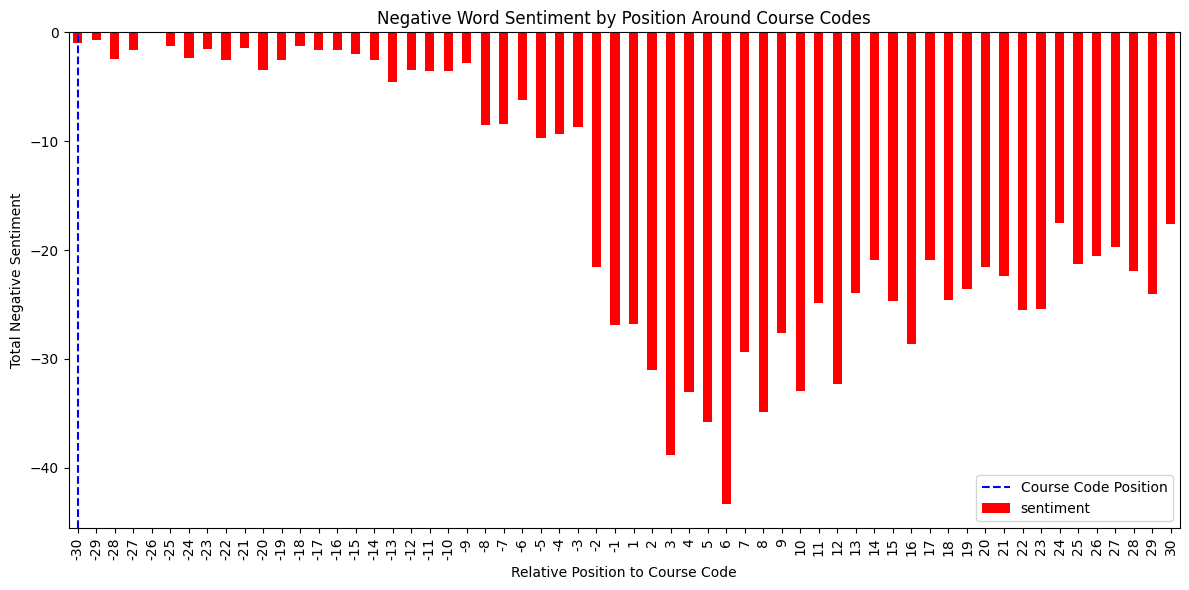

In [18]:
# sentiment_by_position.py

import matplotlib.pyplot as plt
import pandas as pd

# Only negative sentiment words
negatives = proximity_df[proximity_df['sentiment'] < 0]

# Group by position, sum sentiment (more negative = larger bar)
neg_sums = negatives.groupby('relative_position')['sentiment'].sum()

# Plot
plt.figure(figsize=(12, 6))
neg_sums.plot(kind='bar', color='red')

plt.axvline(0, color='blue', linestyle='--', label='Course Code Position')
plt.xlabel('Relative Position to Course Code')
plt.ylabel('Total Negative Sentiment')
plt.title('Negative Word Sentiment by Position Around Course Codes')
plt.legend()
plt.tight_layout()
plt.show()

### observation: the most negative words used around course codes, in negative posts, are from pos -2 to +10 or +20
Plan: find what these words are, using n-grams

In [19]:
# extract_proximity_df and KEEP WORD 
proximity_data = []
for _, row in df_filtered_vader.iterrows():
    for entry in row['proximity_sentiment']:
        proximity_data.append({
            'relative_position': entry['relative_position'],
            'sentiment': entry['sentiment'],
            'word': entry['word']  # <-- Add this line
        })

proximity_df = pd.DataFrame(proximity_data)

### See the negative words, from the negative posts, NEAR the course code mention

In [21]:
neg_words_df = proximity_df[proximity_df['sentiment'] < 0].copy()
neg_words_df['word'] = neg_words_df['word'].str.lower()

summary = (
    neg_words_df.groupby('word')
    .agg(vader_compound=('sentiment', 'first'), frequency=('word', 'count'))
    .sort_values(by='frequency', ascending=False)
    .reset_index()
)

print(summary.head(20))

          word  vader_compound  frequency
0       failed         -0.5106        241
1           no         -0.2960        144
2   struggling         -0.4215        118
3         hard         -0.1027        106
4        stuck         -0.2500         69
5     confused         -0.3182         50
6        error         -0.4019         41
7      missing         -0.2960         35
8      trouble         -0.4019         34
9        wrong         -0.4767         33
10   difficult         -0.3612         32
11        fail         -0.5423         31
12     nervous         -0.2732         31
13  difficulty         -0.3400         30
14      tricks         -0.1280         29
15      missed         -0.2960         25
16     problem         -0.4019         23
17      scared         -0.4404         22
18    critical         -0.3182         22
19     failing         -0.5106         21


## observation: I think using the actual low-sentiment words will be more effective than n-grams, as there are almost no false-positives 